## Facial Expression CNN Performance Evaluation

The CNN has an top-1 accuracy of 67%, and top-3 accuracy of 93% on validation. It uses a trainable EfficientNet model and succeeding Dense layers. It is trained in the faceexpression.ipynb file.

It has decent metrics throughout - from 0.6 MCC to 0.67 f1/precision scores. This shows that the high regularisation through Early stopping, LR reduction and dropout did help the model generalise and curb overfitting. There is a good degree of class separability and confidence in the model, evinced by its ROC-AUC curve and log loss score.

The misclassification matrix shows that more identifiable emotions like happy, surprise and disgust had very high scores - but more complex and overlapping features like sad and fear had lower scores.

Nevertheless, the model achieves human-level accuracy on this dataset. The highest recorded accuracies on this dataset are 83% and 74% - and they both used pretrained models, extra training data and even attention mechanisms. This model adds in image augmentation, and generates top-1 67% accuracy with no ensembles and no extra training data/attention.

The dataset in itself had to be upscaled and morphed to ensure regularisation. This dataset contains very specific labels, various photo angles, and severe class imbalance. It is also only a 48x48 pixel grid that too in grayscale. To counter this, images were upsized 3x and class weights were calculated. These worked extremely well too, since disgust - the least represented class - was one of the most accurately classified. 

### Implemented by Pratham Shah

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import TopKCategoricalAccuracy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, auc, roc_curve, log_loss, accuracy_score, precision_score, f1_score, recall_score
import seaborn as sns
import os
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.calibration import label_binarize

2025-06-27 09:43:10.154848: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 09:43:10.251905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750997590.289384    9565 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750997590.301075    9565 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750997590.382206    9565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Loading the Model

Trained in the other file, best weights saved.

In [ ]:
model = load_model('best_model.h5') #loading the model trained in the other file

2025-06-27 09:43:13.003581: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Loading the Validation and Training Sets

Note the upscaling and extra channels to match the training input and allow EfficientNet to process the data.

In [ ]:
datagen = ImageDataGenerator()

testing = datagen.flow_from_directory(
    'images/validation',
    target_size=(224, 224),
    color_mode='rgb', #3channel
    batch_size=64,
    class_mode='categorical', #onehot
    shuffle=False #preserves order
)

training = datagen.flow_from_directory(
    'images/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
)

Found 7066 images belonging to 7 classes.
Found 28821 images belonging to 7 classes.


## EDA to Show Class Imbalance

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


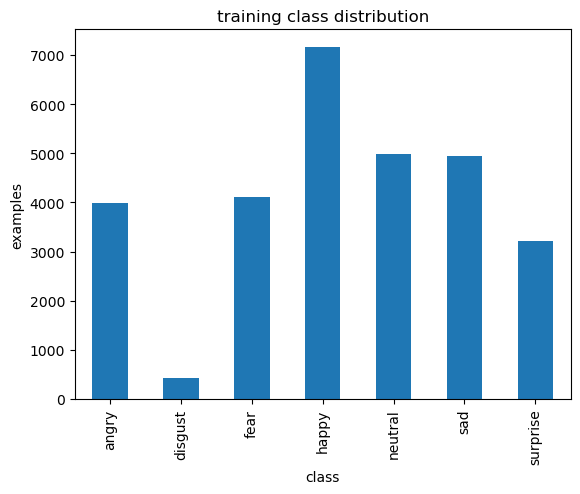

In [4]:
class_counts = pd.Series(training.classes).value_counts().sort_index()

class_names = list(training.class_indices.keys())
print(training.class_indices)

class_counts.plot(kind="bar")

plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.xlabel("class")
plt.ylabel("examples")
plt.title("training class distribution")
plt.show()

In [5]:
te = model.evaluate(testing)
tr = model.evaluate(training)

/home/pratham/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6261 - loss: 1.3859
451/451 ━━━━━━━━━━━━━━━━━━━━ 587s 1s/step - accuracy: 0.7410 - loss: 1.2206


In [6]:
predictions = model.predict(testing)

111/111 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step


## Accuracy and Loss on Train and Test

Continual saving and manual stopping helped save the model that had the highest accuracies on both the validation and the training data.

The model appears to have slightly overfit, but the testing accuracy kept going up (67 is the highest recorded) and the model was manually stopped before the accuracy difference got too high.

In [7]:
for item in tr, te:
    print(f"Accuracy: {item[1]}")
    print(f"loss: {item[0]}")

Accuracy: 0.7421671748161316
loss: 1.218389630317688
Accuracy: 0.6701104044914246
loss: 1.3217281103134155


## Classification Metrics and Confusion Matrix

Almost all classes achieved high classification numbers in the classification report.

Note the very high scores for happy and surprise, along with disgust and anger. Also note the exceptional scores for disgust - which though the least in number in the training set - has achieved relatively high scores.

Note the low scores for fear and sad - these emotions are visually less discernible and often overlap with other classe's visual cues. Infact misclassifications between sad and neutral/fear are the highest in the misclassifcation matrix.

Also observe the softmax output here in terms of probabilities. The first example has a max value of 59% - highlighting that the model is not entirely sure about the prediction.

example of the cnn output showing probabilities:
[0.5951121  0.03856826 0.1141881  0.03595645 0.064107   0.12020876
 0.03185938]
              precision    recall  f1-score   support

       angry       0.56      0.60      0.58       960
     disgust       0.59      0.72      0.65       111
        fear       0.57      0.42      0.48      1018
       happy       0.91      0.83      0.87      1825
     neutral       0.58      0.72      0.64      1216
         sad       0.56      0.51      0.53      1139
    surprise       0.71      0.85      0.78       797

    accuracy                           0.67      7066
   macro avg       0.64      0.66      0.65      7066
weighted avg       0.67      0.67      0.67      7066



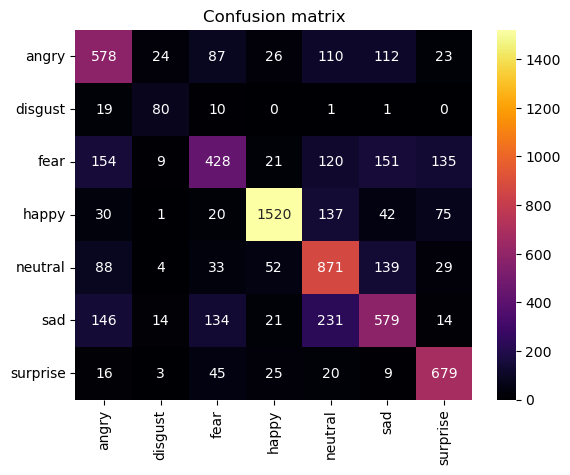

In [ ]:
print("example of the cnn output showing probabilities:")
print(predictions[0]) #0-1 output for probability values of classes

final = np.argmax(predictions) #converts row into single value of highest prob. index = class ID
real_labels = testing.classes

indexed_items = list(testing.class_indices.keys())

print(classification_report(real_labels, final, target_names = indexed_items)) #classification report and confusion matrix

cm = confusion_matrix(real_labels, final)
sns.heatmap(cm, annot=True, fmt='d', cmap="inferno")
plt.title("Confusion matrix")
plt.xticks(np.arange(7) + 0.5, indexed_items, rotation=90)
plt.yticks(np.arange(7) + 0.5, indexed_items, rotation=0)
plt.show()

## Misclassification Report

Sad and neutral/fear have the highest misclassifications. Following is fear with surprise.

These misclassifications, though significant - are expected due to the visual resemblance of these emotions on human faces (especially small images like on FER2013).

Sadness and neutrality are visually similar and also hard for humans to classify. Similarly with fear and surprise - both express shock.

Text(0.5, 1.0, 'Misclassification report')

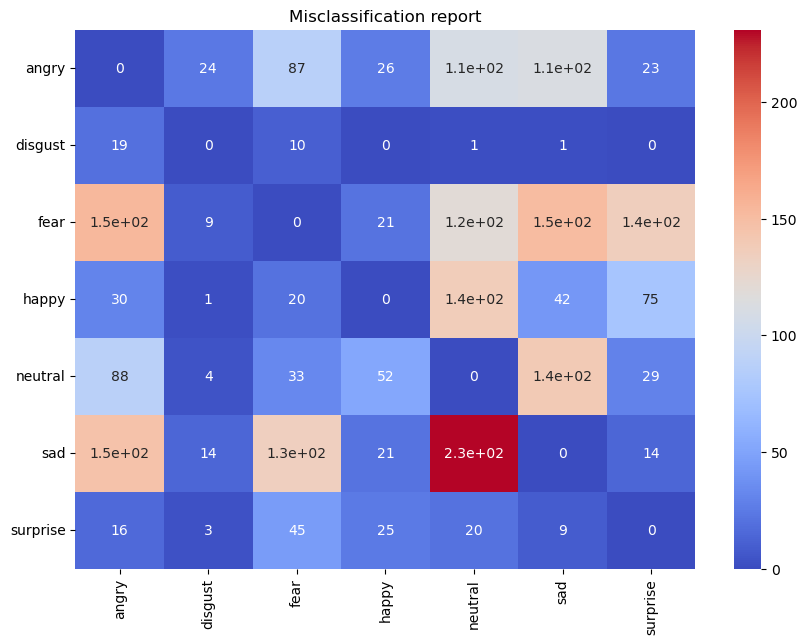

In [9]:
plt.figure(figsize=(10,7))
np.fill_diagonal(cm, 0) #removing all correctly classified examples - in the diagonal
sns.heatmap(cm, annot=True, cmap="coolwarm")
plt.xticks(np.arange(7) + 0.5, indexed_items, rotation=90)
plt.yticks(np.arange(7) + 0.5, indexed_items, rotation=0)
plt.title("Misclassification report")


## Examples of Misclassified Images

The following misclassified image examples show how the model - just like humans - is making decent but slightly incorrect predictions on hard images. 

Even humans are likely to misclassify these images without additional context.

The model isn't making serious errors - like mixing disgust and happiness (0 misclassifications).

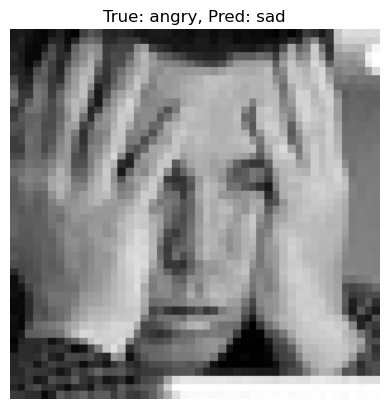

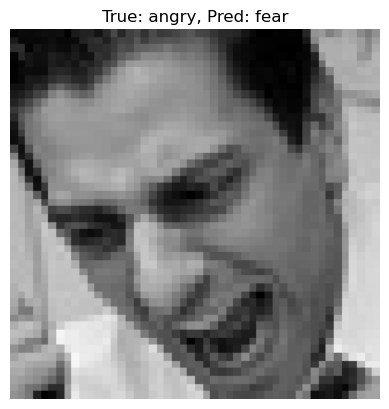

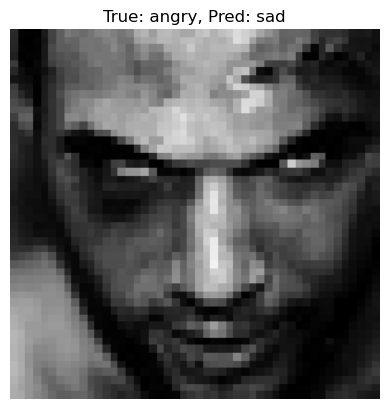

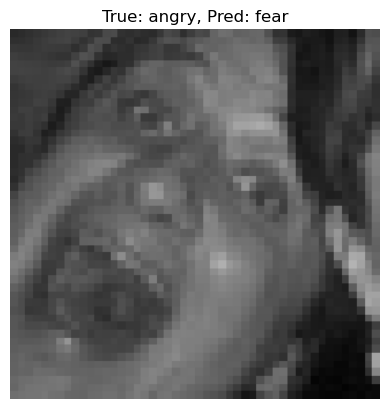

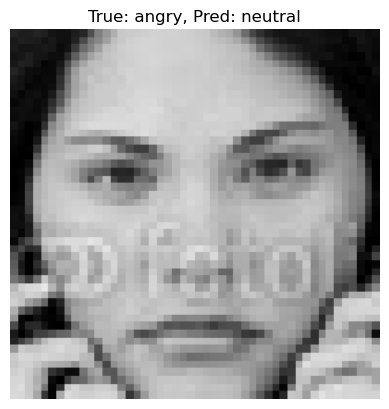

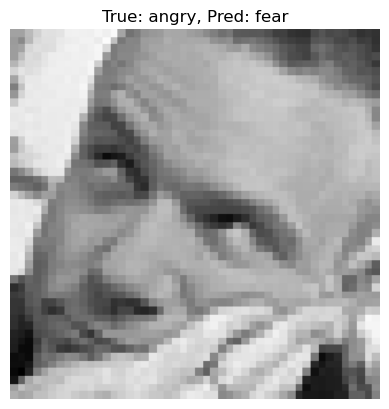

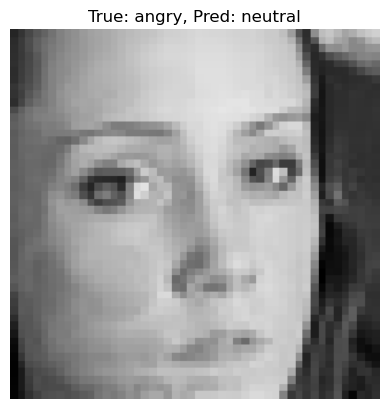

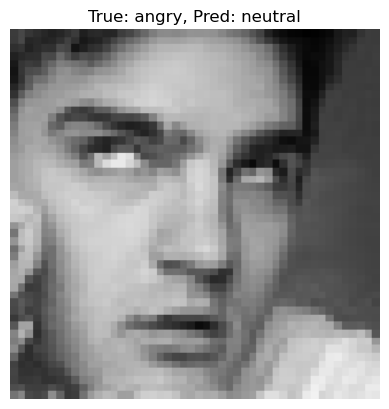

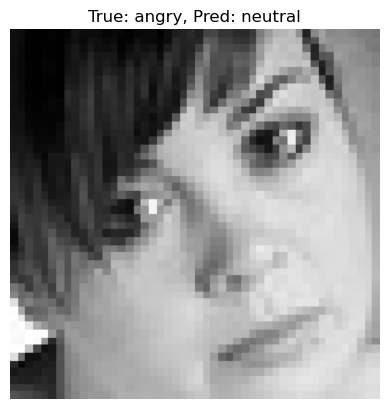

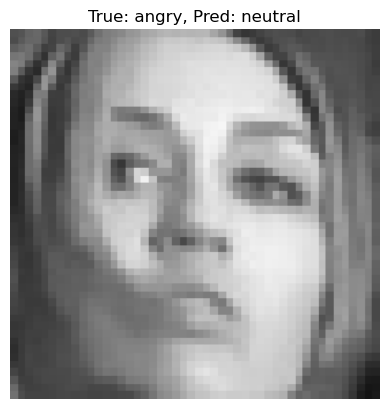

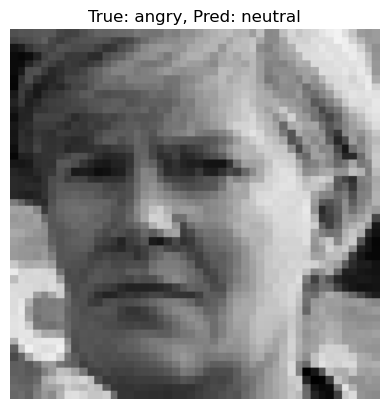

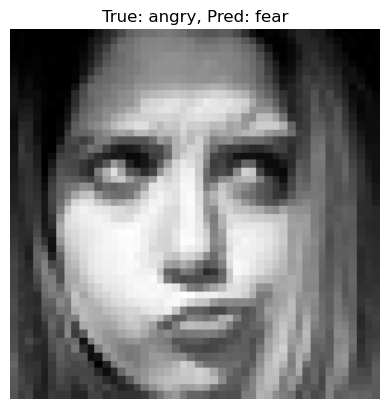

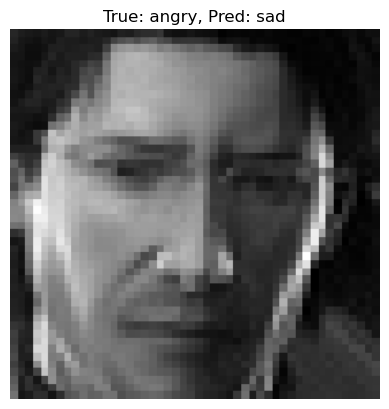

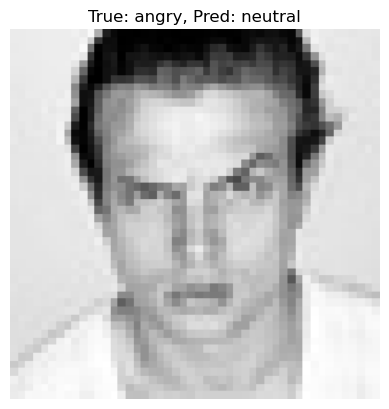

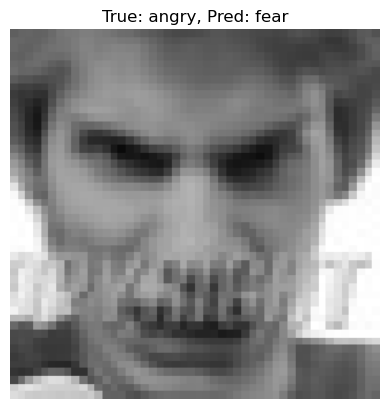

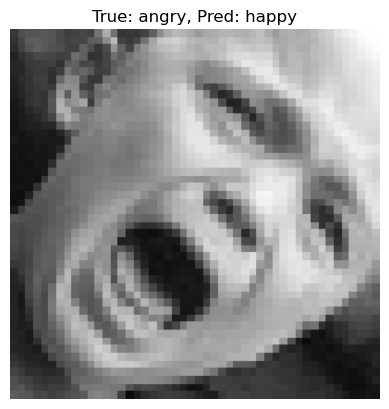

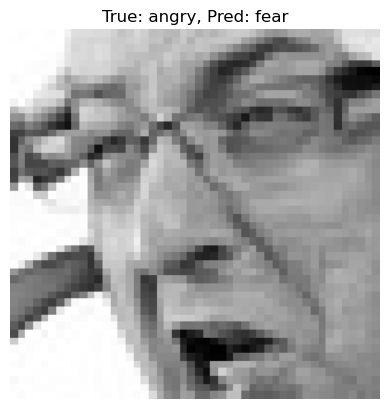

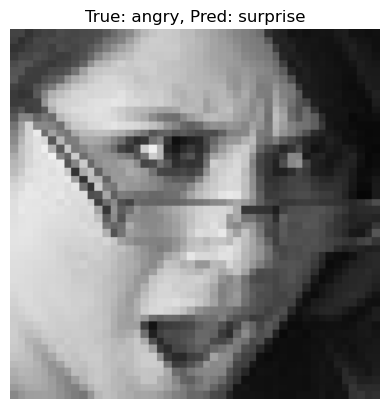

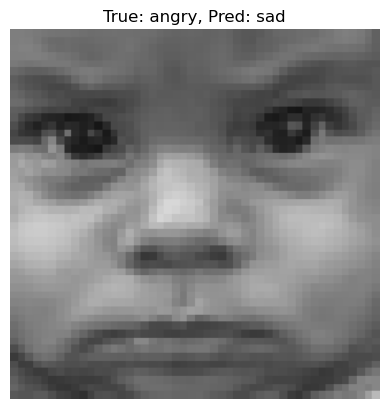

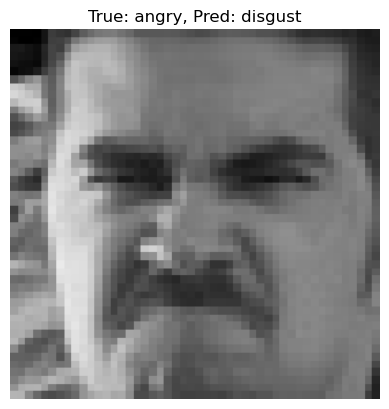

In [10]:
filenames = testing.filenames
errors = np.where(final != real_labels)[0]

for i in errors[:20]:
    # Load image using testing.directory + filenames[i]
    img_path = os.path.join(testing.directory, filenames[i])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype("uint8")
    
    plt.imshow(img_array.astype("uint8"))
    plt.title(f"True: {indexed_items[real_labels[i]]}, Pred: {indexed_items[final[i]]}")
    plt.axis("off")
    plt.show()


## Advanced Metrics

The relatively high MCC score shows a balanced, generalised model. This is complemented by a high f1 score - indicative of high balance and scores for precision and recall.

Note the top-3 accuracy of ~93%. This shows high predictive power, and most misclassifications of the model were only slightly semantically incorrect.

The log loss <1 shows a decently confident model and a 67% accuracy shows that these predictions are indeed valid.

In [ ]:
print(f"Matthew's Correlation Coefficient : {matthews_corrcoef(real_labels, final)}")
print(f"Accuracy : {accuracy_score(real_labels, final)}") #TP+TN / TP+FP+TN+FN
print(f"f1 score : {f1_score(real_labels, final, average='weighted')}") #2pr/p+r
print(f"Log loss : {log_loss(real_labels, predictions)}") #1/n sum -ylogp
print(f"Recall : {recall_score(real_labels, final, average='weighted')}") #TP/real P
print(f"Precision : {precision_score(real_labels, final, average='weighted')}") #TP/predicted P

#weighted: weighted on class, macro: classwise average, micro: example-wise average

top3_pred = np.argsort(predictions)[:, -3:] #top 3 predicted facial expressions (indexes of the last 3 ascending items for all predictinos)

match_array = [real_labels[i] in top3_pred[i] for i in range(len(real_labels))] #row of 0s and 1s - mean gives accuracy
np.mean(match_array)
print("Top-3 Accuracy:", np.mean(match_array)) #counts top 3 predictions for


Matthew's Correlation Coefficient : 0.603351254130662
Accuracy : 0.6701103877724314
f1 score : 0.6677088554038262
Log loss : 0.9567711593378865
Recall : 0.6701103877724314
Precision : 0.6738624677899407
Top-3 Accuracy: 0.9265496744975941


## ROC AUC Curve

1-v/s-rest ROC AUC curves for all classes. Note the very high scores for happy, surprise and disgust. Fear gets the least score, but still has a decent area under the curve at 85%.

The ROC AUC curves also show high separability for most classes, with an exception being happy and surprise.

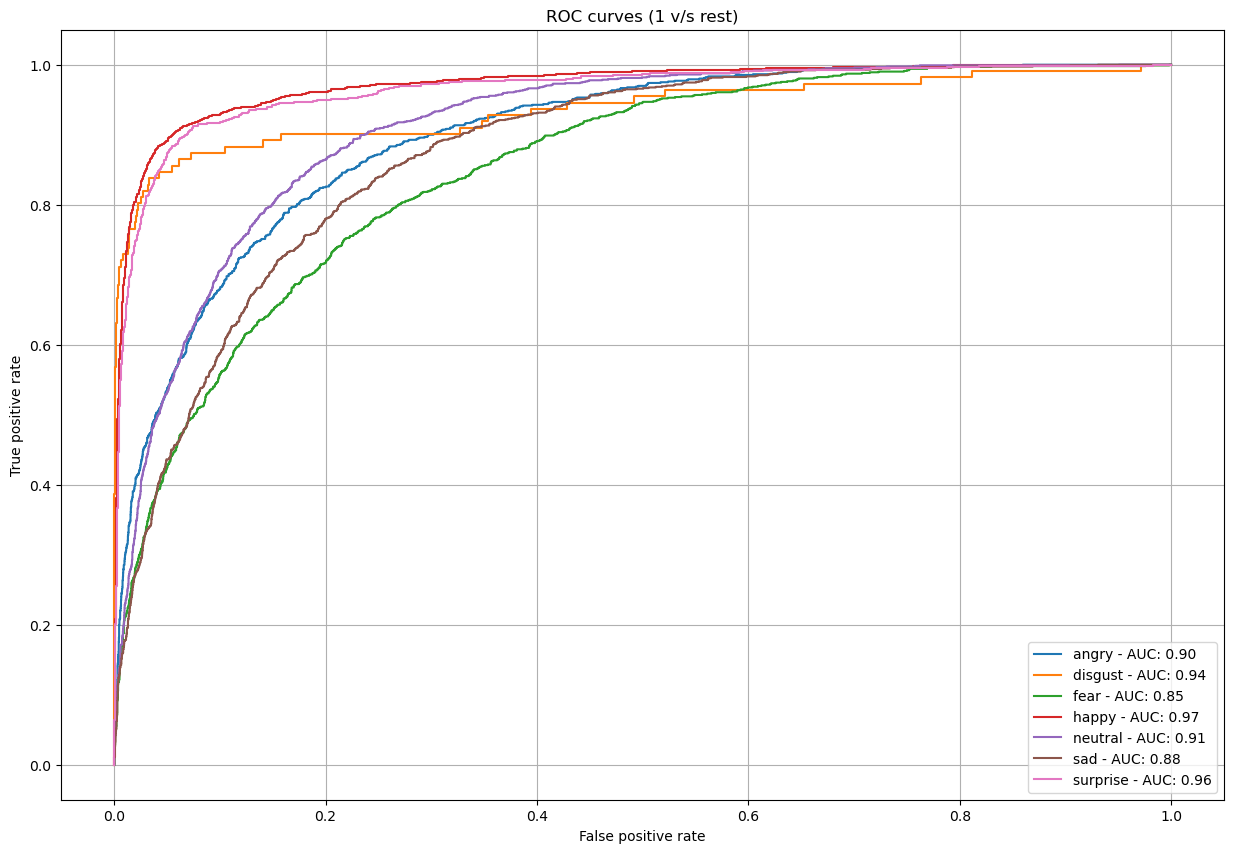

In [ ]:
real_bin = label_binarize(real_labels, classes=np.arange(10))
# real labels = [1, 2, 7, 4, etc] -> [[one hot for 1], [one hot for 2], [one hot for 7], [one hot for 4]]

plt.figure(figsize=(15, 10))

for i in range(7):
    
    false_p_rate, true_p_rate, thresholds = roc_curve(real_bin[:, i], predictions[:, i])
    
    roc_auc = auc(false_p_rate, true_p_rate) #higher area under curve - straighter the lines - lesser the FPR
    
    plt.plot(false_p_rate, true_p_rate, label=f"{indexed_items[i]} - AUC: {roc_auc:.2f}")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves (1 v/s rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Conclusion

The model does not have a state-of-the-art accuracy, but presents good regularisation and generalisation principles, robust data augmentation, model training and saving techniques, countermeasures for class imbalance, and advanced classification analysis.

These all come together, using transfer learning, to deliver a model that classifies most emotions with an acceptable degree of separability and confidence, in a generalised and understandable form. 

The model's scores are promising and show real predictive power and decision-making ability. It does misclassify lots of examples, but this is also in part attributed to visual characteristics of faces.

Thus, this model provides human-level accuracy on the FER2013 dataset, solving the problem it poses.